<div style="text-align: right"> __ Provided on May 27 and due on June 17__ [BRI516, Spring/2019] </div>

For homework in general:
* Install `Anaconda` and create an environment with `NumPy`, `Pandas`, `Matplotlib`, `scikit-learn` in Python 3.5 
* Please upload your jupyter-notebook file for homework to `Blackboard`
* Please visualize the results as much as possible and discuss your results at least one line of text

In [26]:
# Disable warning message
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [27]:
# import library & module
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

import os
import struct
import numpy as np

#### [Hw05] Implementing a Multilayer Neural Networks using TensorFlow (TF) 1.x (Ch. 13)


##### (1) Data preparation
    (1a) Load the train dataset and test dataset of the MNIST 
    

  

In [28]:
# import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets("./data/mnist/", validation_size=5000)

Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz


    (1b) Set the first 55,000 samples in the training dataset as training data, the remaining 5,000 samples in the training dataset as validation data, and 10,000 samples in the test dataset as test data.

In [36]:
## Set the first 55,000 samples in the training dataset as training data
X_train = mnist_data.train.images
y_train = mnist_data.train.labels
print('training data\n rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

training data
 rows: 55000, columns: 784


In [37]:
# the remaining 5,000 samples in the training dataset as validation data
X_validation = mnist_data.validation.images
y_validation = mnist_data.validation.labels
print('validation data\n rows: %d, columns: %d' % (X_validation.shape[0], X_validation.shape[1]))

validation data
 rows: 5000, columns: 784


In [38]:
# 10,000 samples in the test dataset as test data
X_test = mnist_data.test.images
y_test = mnist_data.test.labels
print('test data\n rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

test data
 rows: 10000, columns: 784


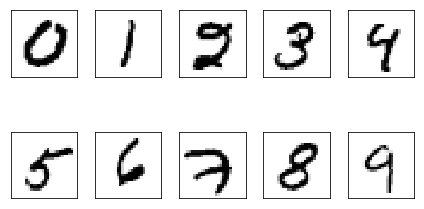

In [39]:
# check
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

##### (2) Multilayer perceptron (MLP) using the low-level API of TF (e.g., p. 429)
    (2a) Implement the multilayer perceptron (MLP) with two hidden layers for classification, and evaluate performance in the following scenarios
    
        (2a-1) for a few choices of hidden nodes per hidden layer
        
        (2a-2) for a few choices of activation functions (i.e., sigmoid, tanh, and ReLU)

    (2b) Add the L2-norm regularization of weights to (2a) and evalute performance for a few choices of L2-norm regularization parameters. For this, please pick the best-performing model from (2a)

    (2c) Evaluate the performance of (2b) for a few options of mini-batch sizes 

    (2d) Commonly for the results for (2a) - (2c), discuss the results such as by presenting convergence curves of cost and/or accuracy and by exemplifying the misclassified digits